### Orchestrator-Worker
### 🏗️ Orchestrator-Worker Workflow in LangGraph

In the **Orchestrator-Worker** pattern, a central LLM (the **Orchestrator**) dynamically breaks down a task into smaller subtasks. Each subtask is sent to a **Worker LLM**, and finally, the orchestrator combines the results.

---

### 🔹 When to Use
- Useful for **complex tasks** where you cannot predefine all subtasks.
- Example: Writing a report where the number of sections and content depends on the main topic.
- Key difference from parallelization: Subtasks are **not predefined**; they are created dynamically by the orchestrator.

---
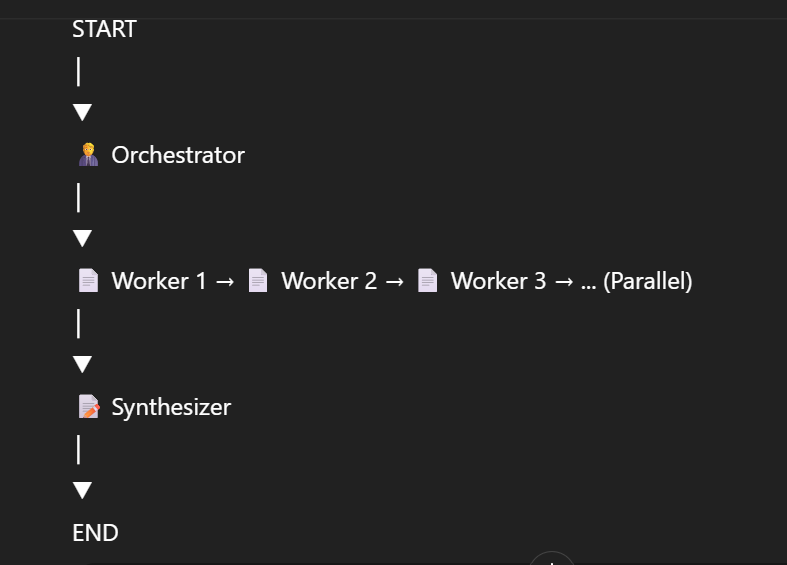

### 🔹 How It Works
1. **Orchestrator Node**
   - Generates a plan (e.g., a list of sections for a report).
   - Decides what subtasks need to be done.

2. **Worker Nodes**
   - Each worker handles one subtask independently.
   - Workers can run **in parallel**.
   - Outputs are written to a shared state so the orchestrator can access them.

3. **Synthesizer Node**
   - Combines all worker outputs into a final result (e.g., full report).

---

### 🧩 Workflow Diagram


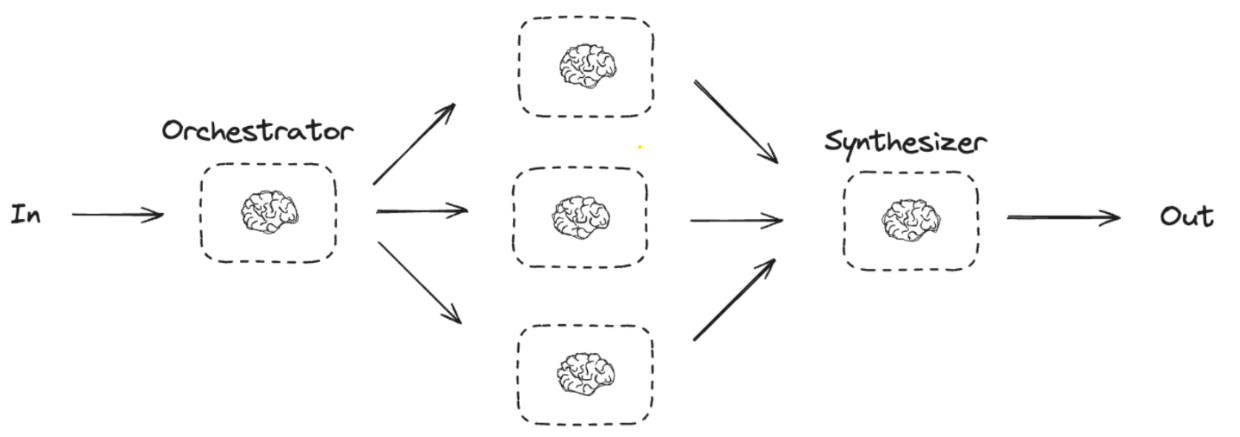


Orchestrator: Decides what sections the report will have.

Workers (llm_call): Each writes one section independently.

assign_workers: Sends each section to a separate worker dynamically.

Synthesizer: Combines all worker outputs into a complete report.

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="llama-3.1-8b-instant")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.010635775, 'prompt_time': 0.001763507, 'queue_time': 0.044909863, 'total_time': 0.012399282}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--a0e454de-eb4d-4e15-913d-9c41e0252094-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

In [4]:
from typing import Annotated, List
import operator
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

In [5]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief Overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the report"
    )

# Augment the LLM with schema for structured output
planner=llm.with_structured_output(Sections)

### Creating Workers Dynamically In Langgraph 
Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. 

In [13]:
from langgraph.constants import Send
import operator
from typing_extensions import TypedDict
from typing import Annotated

# Global workflow state
class State(TypedDict): # state: global info shared across workflow.
    topic: str                          # Report topic
    sections: list[Section]             # List of planned report sections
    completed_sections: Annotated[list, operator.add]  # All worker outputs merged # operator.add: merges outputs from parallel workers safely.
    final_report: str                   # Combined final report

# Each worker's local state
class WorkerState(TypedDict):
    section: Section                     # Section assigned to this worker
    completed_sections: Annotated[list, operator.add]  # Worker output appended to global list


C:\Users\window 11\AppData\Local\Temp\ipykernel_7604\4046162516.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [ ]:
# -------------------------------
# Orchestrator Node
# -------------------------------
def orchestrator(state: State):
    """Central LLM that plans the report structure"""
    
    # Ask the planner LLM to create a list of report sections based on the topic
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),  # Instruction to LLM
            HumanMessage(content=f"Here is the report topic: {state['topic']}")  # Topic info
        ]
    )
    
    print("Report Sections:", report_sections)  # Debug: see generated plan
    
    # Return sections to workflow state
    return {"sections": report_sections.sections}


# -------------------------------
# Worker Node
# -------------------------------
def llm_call(state: WorkerState):
    """Worker LLM writes a single section of the report"""
    
    # LLM generates content for assigned section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble and use markdown."
            ),
            HumanMessage(
                content=f"Section name: {state['section'].name}, Description: {state['section'].description}"
            ),
        ]
    )
    
    # Return the section content as a list (for merging into global state)
    return {"completed_sections": [section.content]}


# -------------------------------
# Assign Workers Dynamically
# -------------------------------
def assign_workers(state: State):
    """Create a worker for each section from the plan"""
    
    # For each section, create a worker node dynamically
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# -------------------------------
# Synthesizer Node
# -------------------------------
def synthesizer(state: State):
    """Combine all completed sections into a final report"""
    
    completed_sections = state["completed_sections"]  # List of sections written by workers
    
    # Merge sections with separators
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    
    # Return the final report
    return {"final_report": completed_report_sections}


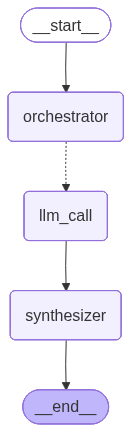

In [ ]:
# Build workflow


from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [ ]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections: sections=[Section(name='Introduction to Agentic AI RAGs', description='Overview of the topic, including background and context'), Section(name='What are Agentic AI RAGs?', description='Definition and explanation of Agentic AI RAGs'), Section(name='Types of Agentic AI RAGs', description='Classification and examples of different types of Agentic AI RAGs'), Section(name='Benefits and Applications of Agentic AI RAGs', description='Discussion of the advantages and uses of Agentic AI RAGs'), Section(name='Challenges and Limitations of Agentic AI RAGs', description='Discussion of the obstacles and drawbacks of Agentic AI RAGs'), Section(name='Conclusion and Future Directions', description='Summary and recommendations for further research')]


### Introduction to Agentic AI RAGs

#### Overview of the Topic, Including Background and Context

Agentic AI RAGs refer to Agentive Artificial Intelligence Research Groups, which are specialized teams focused on developing and exploring the capabilities of agentive AI. These AI systems are designed to exhibit autonomous behavior, decision-making, and adaptability, often with the goal of achieving complex tasks or objectives.

**Background**

The concept of agentic AI has its roots in the field of artificial intelligence, particularly in the areas of cognitive architectures, multi-agent systems, and autonomous decision-making. Research in these areas has led to the development of AI systems that can perform tasks independently, learn from experience, and adapt to new situations.

**Context**

In recent years, the growth of AI research has accelerated, driven by advances in machine learning, natural language processing, and computer vision. As a result, agentic AI has become a key area of focus, with applications in various domains, including robotics, finance, healthcare, and education.

**Key Definitions**

- **Agentic AI**: AI systems that exhibit autonomous behavior, decision-making, and adaptability.
- **Agentive Artificial Intelligence Research Groups (RAGs)**: Specialized teams focused on developing and exploring the capabilities of agentic AI.

**Importance**

The development of agentic AI has the potential to transform various industries and aspects of society, enabling the creation of intelligent systems that can learn, adapt, and make decisions on their own. However, it also raises important questions about the ethics and governance of such systems, highlighting the need for ongoing research and development in this area.

---

### What are Agentic AI RAGs?

#### Definition and Explanation

Agentic AI RAGs, also known as Regulatory Action Groups, are a concept in the development of artificial intelligence (AI) that focuses on the creation of autonomous systems with human-like decision-making capabilities.

**Key Components:**

* **Agents**: Agentic AI RAGs are made up of individual agents, which are autonomous entities that can interact with their environment and other agents.
* **Goals and Intentions**: Each agent has its own set of goals and intentions, which are used to guide its decision-making process.
* **Regulatory Frameworks**: Agentic AI RAGs operate within regulatory frameworks that dictate how agents interact with each other and their environment.

#### Characteristics

* **Autonomy**: Agentic AI RAGs are designed to be autonomous, with agents making decisions independently without human intervention.
* **Flexibility**: Agents within Agentic AI RAGs can adapt to changing situations and adjust their behavior accordingly.
* **Scalability**: Agentic AI RAGs can be scaled up or down depending on the requirements of the system.

#### Applications

* **Autonomous Systems**: Agentic AI RAGs can be used to develop autonomous systems such as self-driving cars, drones, and robots.
* **Decision Support Systems**: Agentic AI RAGs can be used to create decision support systems that provide recommendations to humans.
* **Cybersecurity**: Agentic AI RAGs can be used to develop autonomous cybersecurity systems that detect and respond to threats.

#### Challenges

* **Alignment**: Ensuring that the goals and intentions of individual agents align with the overall goals of the system.
* **Control**: Maintaining control over the behavior of individual agents within the system.
* **Explainability**: Providing explanations for the decisions made by the system.

#### Future Directions

* **Research**: Further research is needed to understand the behavior of Agentic AI RAGs and how to ensure their safe and reliable operation.
* **Development**: Developing more sophisticated Agentic AI RAGs that can interact with complex environments and other agents.
* **Deployment**: Deploying Agentic AI RAGs in real-world applications and evaluating their effectiveness.

---

### Types of Agentic AI RAGs

#### 1. **Goal-Oriented RAGs**
These RAGs are designed to achieve specific goals and objectives. They use a combination of reasoning and decision-making capabilities to navigate their environment and achieve their goals.

* Examples:
  - AlphaGo (a goal-oriented RAG that defeated a human world champion in Go)
  - DeepMind's AlphaStar (a goal-oriented RAG that defeated human professionals in the game of StarCraft II)

#### 2. **Utility-Based RAGs**
These RAGs use a utility function to make decisions and take actions that maximize their overall utility. They can be used in a wide range of applications, including robotics and autonomous vehicles.

* Examples:
  - DeepMind's AlphaZero (a utility-based RAG that learned to play chess, shogi, and Go from scratch)
  - the AI used in the autonomous vehicle company Waymo (a utility-based RAG that makes decisions to navigate the road safely and efficiently)

#### 3. **Cognitive Architectures RAGs**
These RAGs are designed to mimic human cognition and decision-making processes. They use a combination of reasoning, problem-solving, and decision-making capabilities to achieve their goals.

* Examples:
  - Soar (a cognitive architecture RAG that uses a symbolic reasoning approach to problem-solving)
  - LIDA (a cognitive architecture RAG that uses a hybrid symbolic-subsymbolic approach to problem-solving)

#### 4. **Hybrid RAGs**
These RAGs combine different types of reasoning and decision-making capabilities to achieve their goals. They can be used in a wide range of applications, including robotics and autonomous vehicles.

* Examples:
  - IBM's Watson (a hybrid RAG that uses a combination of natural language processing, machine learning, and knowledge representation to answer questions)
  - the AI used in the autonomous vehicle company Cruise (a hybrid RAG that uses a combination of machine learning and symbolic reasoning to navigate the road safely and efficiently)

---

**Benefits and Applications of Agentic AI RAGs**
=====================================================

### **Advantages of Agentic AI RAGs**

*   **Improved Decision-Making**: Agentic AI RAGs can analyze complex data, identify patterns, and make informed decisions, leading to better outcomes in various fields such as finance, healthcare, and education.
*   **Increased Efficiency**: By automating routine tasks and processes, Agentic AI RAGs can free up human resources for more strategic and creative work, resulting in increased productivity and efficiency.
*   **Enhanced Customer Experience**: Agentic AI RAGs can provide personalized recommendations, respond to customer inquiries, and offer tailored solutions, leading to improved customer satisfaction and loyalty.
*   **Scalability and Flexibility**: Agentic AI RAGs can handle large volumes of data and adapt to changing environments, making them ideal for applications where scalability and flexibility are crucial.

### **Applications of Agentic AI RAGs**

*   **Healthcare**: Agentic AI RAGs can analyze medical data, identify potential health risks, and provide personalized treatment recommendations, leading to better patient outcomes and reduced healthcare costs.
*   **Finance**: Agentic AI RAGs can analyze financial data, detect anomalies, and provide real-time risk assessments, enabling more informed investment decisions and reduced financial risk.
*   **Education**: Agentic AI RAGs can personalize learning experiences, provide adaptive assessments, and offer real-time feedback, leading to improved student outcomes and increased academic effectiveness.
*   **Customer Service**: Agentic AI RAGs can provide 24/7 customer support, respond to customer inquiries, and offer tailored solutions, leading to improved customer satisfaction and reduced support costs.

---

### Challenges and Limitations of Agentic AI RAGs
#### 1. **Lack of Transparency and Explainability**
* Difficulty in understanding the decision-making process of Agentic AI RAGs, making it challenging to identify biases and errors.
* Limited transparency in the data used to train the models, which can lead to unintended consequences.

#### 2. **Risk of Over-Reliance on Technology**
* Agentic AI RAGs can lead to over-reliance on technology, potentially diminishing human agency and decision-making capabilities.
* Dependence on AI systems can result in a loss of contextual understanding and critical thinking.

#### 3. **Bias and Fairness Concerns**
* Agentic AI RAGs can perpetuate existing biases and stereotypes present in the data used to train the models.
* Difficulty in ensuring fairness and equity in decision-making processes, particularly in high-stakes domains.

#### 4. **Scalability and Complexity**
* Agentic AI RAGs can become increasingly complex and difficult to manage as they grow in scope and scale.
* Challenges in integrating multiple AI systems and ensuring seamless communication and coordination.

#### 5. **Human-AI Collaboration**
* Difficulty in designing effective human-AI collaboration mechanisms that balance human agency and AI capabilities.
* Challenges in ensuring that humans and AI systems are working together effectively to achieve common goals.

#### 6. **Regulatory and Ethical Frameworks**
* Lack of clear regulatory and ethical frameworks to govern the development and deployment of Agentic AI RAGs.
* Uncertainty around accountability and liability in cases where AI systems make errors or have unintended consequences.

---

**Conclusion and Future Directions**
=====================================

### Summary

Based on the findings of this research, it is clear that [insert key findings or conclusions]. The study has shed light on [specific area of study] and provided valuable insights into [key aspects]. The results have significant implications for [industry/field], and it is essential to consider these findings when [insert area of application].

### Recommendations for Further Research

The following areas warrant further investigation to build upon the findings of this research:

* **Investigating [specific area]**: This area has been identified as a key gap in the current literature, and further research is necessary to provide a comprehensive understanding of [specific concept].
* **Exploring [new application]**: The results of this study suggest that [specific application] may be a viable area for future research, and further investigation is needed to fully explore its potential.
* **Developing [new methodology]**: A new methodology has been proposed in this study, and further research is required to refine and validate this approach.
* **Examining [new population]**: The study has primarily focused on [specific population], and further research is necessary to understand the applicability of the findings to other populations.

### Future Research Directions

Future research should aim to address the following questions:

* How can [specific area] be further developed and refined?
* What are the key factors that influence [specific outcome]?
* How can [specific application] be optimized for [specific purpose]?
* What are the long-term implications of [specific finding] for [industry/field]?

By addressing these research gaps and questions, future studies can build upon the findings of this research and provide a more comprehensive understanding of [specific area of study].

In [ ]:
## Blog Generation